In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt

from src.utils import MNIST, train
from src.models import CNN
from src.advattack.FGSM import FGSM
from src.advattack.attacks import test, plot_examples

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DATA

In [30]:
train_dataset, test_dataset, train_loader, test_loader = MNIST()

## MODEL

In [31]:
model = CNN().to(device)

## TRAIN

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 1
train_log, train_acc_log, val_log, val_acc_log =  train(train_loader=train_loader, test_loader=test_loader, model=model, criterion=criterion,opt=optimizer, device=device, n_epochs=num_epochs)
torch.save(model.state_dict(), './checkpoints/simple_cnn_mnist.pth')

## LOAD CHECKPOINT

In [44]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

<All keys matched successfully>

## FGSM

In [37]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies = []
examples = []

attack_model = FGSM(model=model)

for eps in epsilons:

    attack = lambda x,y: attack_model.fgsm_augment(x,y, eps = eps)
    fake_acc, real_acc, ex = test(model, test_loader, attack=attack)
    
    accuracies.append(fake_acc)
    examples.append(ex)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:06<00:00, 25.93it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:05<00:00, 27.08it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.9301959452436601


100%|██████████| 157/157 [00:06<00:00, 24.00it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.7610354358235254


100%|██████████| 157/157 [00:05<00:00, 27.61it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.5100999197881212


100%|██████████| 157/157 [00:06<00:00, 24.00it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.24543620945726363


100%|██████████| 157/157 [00:07<00:00, 21.81it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.09027234758547378


100%|██████████| 157/157 [00:06<00:00, 24.31it/s]

Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.03782871519677066


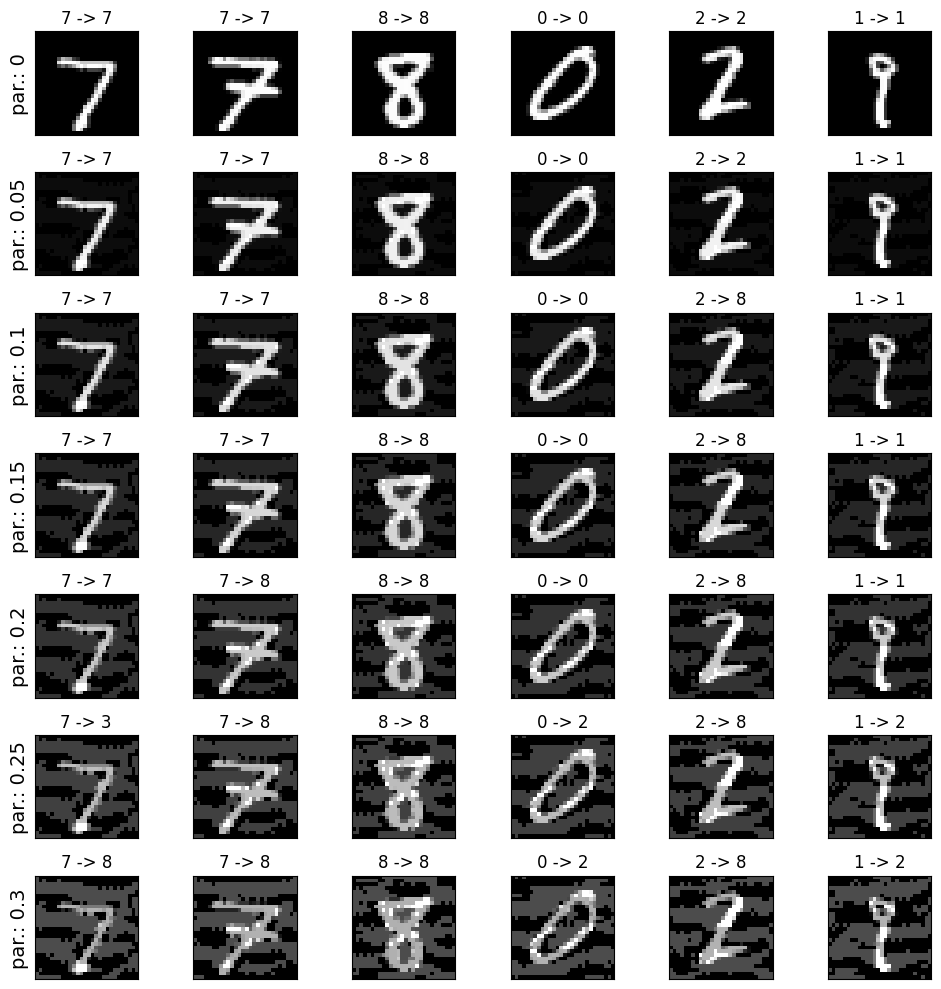

In [48]:
plot_examples(vvalues = epsilons, examples=examples, cnt_ex = 6 )

## AUGMENTATION FGSM finetuning

### Pretrained model

In [66]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

<All keys matched successfully>

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
num_epochs = 1

attack_model = FGSM(model=model)
prepare = lambda x,y: attack_model.fgsm_augment(x,y,eps = 0.1)

train_log, train_acc_log, val_log, val_acc_log =  train(
    train_loader=train_loader, 
    test_loader=test_loader, 
    model=model, 
    criterion=criterion,
    opt=optimizer, 
    device=device, 
    n_epochs=num_epochs, 
    prepare=prepare
    )

torch.save(model.state_dict(), './checkpoints/simple_cnn_mnist_FGSM.pth')

Epoch [1/1], Loss (train/test): 0.0483/0.0460, Acc (train/test): 0.9848/0.9843


### LOAD FINETUNED by FGSM

In [69]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist_FGSM.pth'))

<All keys matched successfully>

In [70]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies_FGSM = []
examples_FGSM = []

attack_model = FGSM(model=model)

for eps in epsilons:

    attack = lambda x,y: attack_model.fgsm_augment(x,y, eps = eps)
    fake_acc, real_acc, ex = test(model, test_loader, attack=attack)
    
    accuracies_FGSM.append(fake_acc)
    examples_FGSM.append(ex)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:06<00:00, 26.16it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:05<00:00, 26.82it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.9840029618345436


100%|██████████| 157/157 [00:05<00:00, 26.31it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.9520046143878839


100%|██████████| 157/157 [00:06<00:00, 26.02it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.8986338574156728


100%|██████████| 157/157 [00:06<00:00, 25.24it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.8059231647055821


100%|██████████| 157/157 [00:05<00:00, 27.91it/s]


Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.6425379052421105


100%|██████████| 157/157 [00:07<00:00, 20.65it/s]

Real Accuracy = 0.9842754777070064, Fake Accuracy on the real true predictions = 0.42240726819531027


## Сравнение моделей

Text(0, 0.5, 'Accuracy')

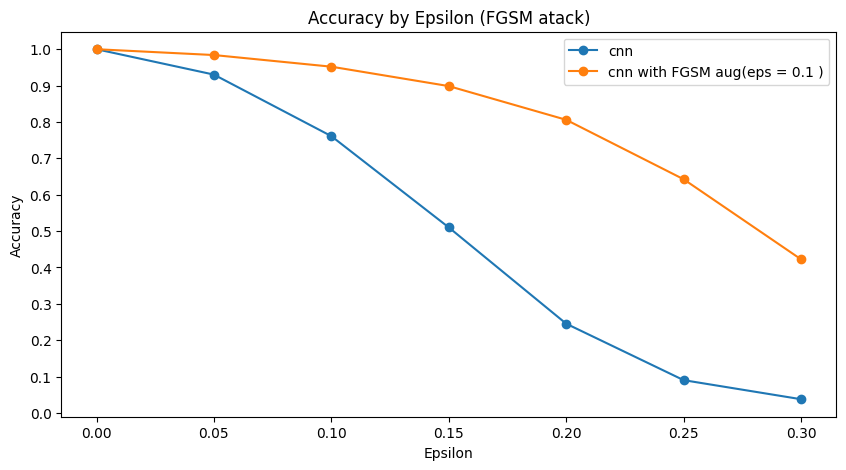

In [71]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, accuracies,'-o', label = 'cnn')
plt.plot(epsilons, accuracies_FGSM,'-o', label = 'cnn with FGSM aug(eps = 0.1 )')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))

plt.title("Accuracy by Epsilon (FGSM atack)")

plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")